# **Задание**

На основании имеющихся данных о клиентах банка требуется построить модель для прогнозирования невыполнения долговых обязательств по текущему кредиту, используя обучающий датасет. Выполнить прогноз для примеров из тестового датасета.

**Исходные данные:**

course_project_train.csv - обучающий датасет

course_project_test.csv - тестовый датасет

**Целевая переменная:**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества:**

F1-score

**Требования к решению:**

F1( 𝛽  = 1) > 0.5 при Precision > 0.5 и Recall > 0.5

Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

**Решение должно содержать:**

Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv
Рекомендации для файла с кодом (ipynb)

Файл должен содержать заголовки и комментарии (markdown).
Повторяющиеся операции лучше оформлять в виде функций.
Не делать вывод большого количества строк таблиц (5-10 достаточно).
По возможности добавлять графики, описывающие данные (около 3-5).

Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта.

Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
Весь проект должен быть в одном скрипте (файл ipynb).
Допускается применение библиотек Python и моделей машинного обучения, которые были в данном курсе.

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - кредитный рейтинг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

# **Импорт библиотек и исходных данных**

In [1]:
! pip install CatBoost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

**Пути к файлам**

In [4]:
TRAIN_DATASET_PATH = '/content/sample_data/course_project_train.csv'
TEST_DATASET_PATH = '/content/sample_data/course_project_test.csv'

In [5]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [6]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
2495,Home Mortgage,1020053.0,10+ years,0.0,14.0,29.1,559152.0,1.0,68.0,1.0,debt consolidation,Short Term,99999999.0,162735.0,15046.0,745.0
2496,Home Mortgage,NaN,2 years,0.0,15.0,17.0,1737780.0,0.0,77.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,NaN
2497,Home Mortgage,1171806.0,2 years,0.0,48.0,12.8,1706430.0,0.0,NaN,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0
2498,Rent,723520.0,10+ years,0.0,14.0,28.8,945780.0,0.0,NaN,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0
2499,Rent,1694439.0,10+ years,0.0,12.0,18.4,1199748.0,1.0,72.0,0.0,debt consolidation,Long Term,763004.0,559531.0,23440.0,6820.0


In [7]:
train_df.shape, test_df.shape

((7500, 17), (2500, 16))

# **Анализ и обработка исходных данных**

**Целевая переменная (Credit Default)**

In [8]:
train_df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [9]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


**Обзор категориальных признаков**

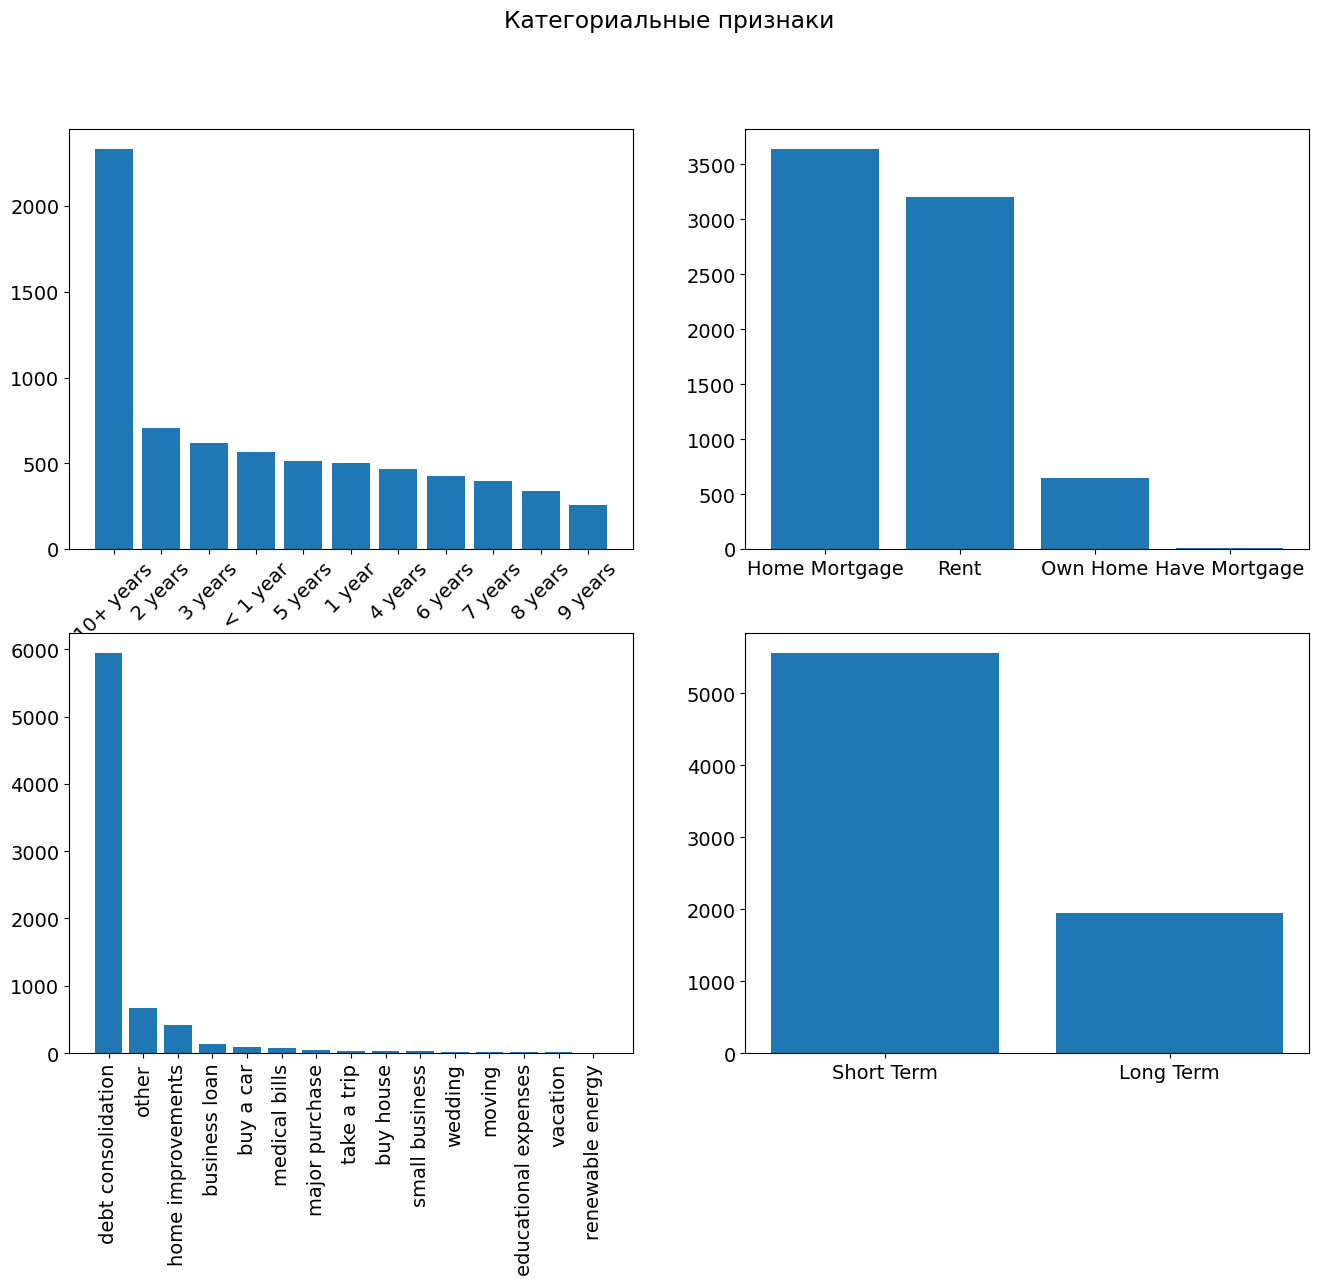

In [10]:
plt.rcParams['figure.figsize'] = [16, 12]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

ax1.bar(train_df['Years in current job'].value_counts().index, train_df['Years in current job'].value_counts().values)
ax2.bar(train_df['Home Ownership'].value_counts().index, train_df['Home Ownership'].value_counts().values)
ax3.bar(train_df['Purpose'].value_counts().index, train_df['Purpose'].value_counts().values)
ax4.bar(train_df['Term'].value_counts().index, train_df['Term'].value_counts().values)

fig.suptitle('Категориальные признаки')
ax1.xaxis.set_tick_params(rotation=45)
ax3.xaxis.set_tick_params(rotation=90)

In [11]:
for cat_colname in train_df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [13]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

**Обработка пропусков**

In [14]:
len(train_df) - train_df.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [15]:
len(test_df) - test_df.count()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

Как видно, в обоих файлах имеются пропуски в столбцах Annual Income, Years in current job,  Months since last delinquent, Bankruptcies, Credit Score.

Выполним следующие преобразования в обоих датасетах:



*   Пустые значения в Years in current job заменим нулями и закодируем категориальные значения как численные.
*   В пустые значения в Annual Income подставим медиану.

*   Пропуски в Months since last delinquent заполним нулями, считая, что просрочки нет.
*   Bankruptcies: пропусков очень мало, заменим нулями.
*   Credit Score: в пропусках пропишем нули.

In [16]:
train_df['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [17]:
test_df['Years in current job'].value_counts()

10+ years    810
3 years      228
2 years      212
< 1 year     207
5 years      169
1 year       153
4 years      152
7 years      140
6 years      137
8 years      107
9 years       99
Name: Years in current job, dtype: int64

Что в train, что в test категории в рамках признака Years in current job имеют одинаковые значения. Поэтому закодируем количество лет на текущем месте работы в большую сторону, при этом сохраняя численную зависимость:
* 10+ years = 11
* 9 years = 10
* 8 years = 9
* 7 years = 8
* 6 years = 7
* 5 years = 6
* 4 years = 5
* 3 years = 4
* 2 years = 3
* 1 year = 2
* < 1 year = 1
* 0 = 0





In [18]:
train_df['Years in current job'] = train_df['Years in current job'].fillna('0').map({'0': 0, 
                                                                                     '< 1 year': 1, 
                                                                                     '1 year': 2, 
                                                                                     '2 years': 3,
                                                                                     '3 years': 4, 
                                                                                     '4 years': 5, 
                                                                                     '5 years': 6, 
                                                                                     '6 years': 7, 
                                                                                     '7 years': 8, 
                                                                                     '8 years': 9, 
                                                                                     '9 years': 10, 
                                                                                     '10+ years': 11})

In [19]:
test_df['Years in current job'] = test_df['Years in current job'].fillna('0').map({'0': 0, 
                                                                                     '< 1 year': 1, 
                                                                                     '1 year': 2, 
                                                                                     '2 years': 3,
                                                                                     '3 years': 4, 
                                                                                     '4 years': 5, 
                                                                                     '5 years': 6, 
                                                                                     '6 years': 7, 
                                                                                     '7 years': 8, 
                                                                                     '8 years': 9, 
                                                                                     '9 years': 10, 
                                                                                     '10+ years': 11})

In [20]:
train_df['Annual Income'].fillna(value=train_df['Annual Income'].mean(), inplace=True)

In [21]:
test_df['Annual Income'].fillna(value=test_df['Annual Income'].mean(), inplace=True)

In [22]:
train_df.loc[:, ['Months since last delinquent', 'Bankruptcies', 'Credit Score']] = train_df.loc[:, ['Months since last delinquent','Bankruptcies', 'Credit Score']].fillna(value=0)

In [23]:
test_df.loc[:, ['Months since last delinquent', 'Bankruptcies', 'Credit Score']] = test_df.loc[:, ['Months since last delinquent','Bankruptcies', 'Credit Score']].fillna(value=0)

In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   int64  
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [25]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 2500 non-null   float64
 2   Years in current job          2500 non-null   int64  
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  2500 non-null   float64
 9   Bankruptcies                  2500 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

Пропуски в обоих датасетах теперь отсутствуют, а признак Years in current job имеет тип данных int64.



**Далее рассмотрим аномалии**

In [26]:
train_df.describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7.500000e+03,7500.000000,7500.000000,7500.000000
mean,1.366392e+06,6.540000,0.030133,11.130933,18.317467,9.451537e+05,0.170000,15.815200,0.116933,1.187318e+07,2.898332e+05,18314.454133,912.121733,0.281733
std,7.524812e+05,3.831826,0.271604,4.908924,7.041946,1.602622e+07,0.498598,22.649441,0.346904,3.192612e+07,3.178714e+05,11926.764673,1502.588014,0.449874
min,1.645970e+05,0.000000,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,0.000000,0.000000
25%,9.311330e+05,3.000000,0.000000,8.000000,13.500000,2.792295e+05,0.000000,0.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,667.000000,0.000000
50%,1.366392e+06,7.000000,0.000000,10.000000,17.000000,4.781590e+05,0.000000,0.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,722.000000,0.000000
75%,1.499974e+06,11.000000,0.000000,14.000000,21.800000,7.935015e+05,0.000000,29.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,740.000000,1.000000
max,1.014934e+07,11.000000,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


Как видно, медианное значение у признака Current Loan Amount существенно отличается от квантиля 50%. Судя по всему, справа есть выбросы. Максимальное значение = 1.000000e+08 (это примерно 100 000 000), 
в то время как 75% квантиль = 5.198820e+05 (519 882). Значение 1.000000e+08 похоже на аномалию. Заменим его на среднее значение.

In [27]:
c_max_value = np.quantile(train_df['Current Loan Amount'], q=0.975)
c_max_value

99999999.0

In [28]:
train_df.loc[train_df['Current Loan Amount'] == 99999999, 'Current Loan Amount'] = train_df['Current Loan Amount'].mean()

In [29]:
test_df.describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,2.500000e+03,2500.000000,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2.500000e+03,2500.000000,2500.000000
mean,1.366922e+06,6.710800,0.035200,11.184400,18.325920,7.105704e+05,0.162000,15.614000,0.106800,1.215572e+07,2.963966e+05,18271.340000,981.194000
std,8.175891e+05,3.791374,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.616348,0.356994,3.226097e+07,3.783020e+05,11543.881469,1629.525434
min,1.065330e+05,0.000000,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,0.000000
25%,9.365622e+05,3.000000,0.000000,8.000000,13.400000,2.785860e+05,0.000000,0.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,668.000000
50%,1.366922e+06,7.000000,0.000000,10.000000,17.000000,4.786760e+05,0.000000,0.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,722.000000
75%,1.488726e+06,11.000000,0.000000,14.000000,22.100000,8.025985e+05,0.000000,27.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,741.000000
max,1.497561e+07,11.000000,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


В test датасете аналогичная картина у максимального значения признака Current 
Loan Amount. Также заменим его на среднее значение.

In [30]:
c_max_value = np.quantile(test_df['Current Loan Amount'], q=0.975)
c_max_value

99999999.0

In [31]:
test_df.loc[train_df['Current Loan Amount'] == 99999999, 'Current Loan Amount'] = test_df['Current Loan Amount'].mean()

**Корреляция таргета с базовыми признаками в train датасете**

In [32]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = train_df.columns.drop(TARGET_NAME).tolist()

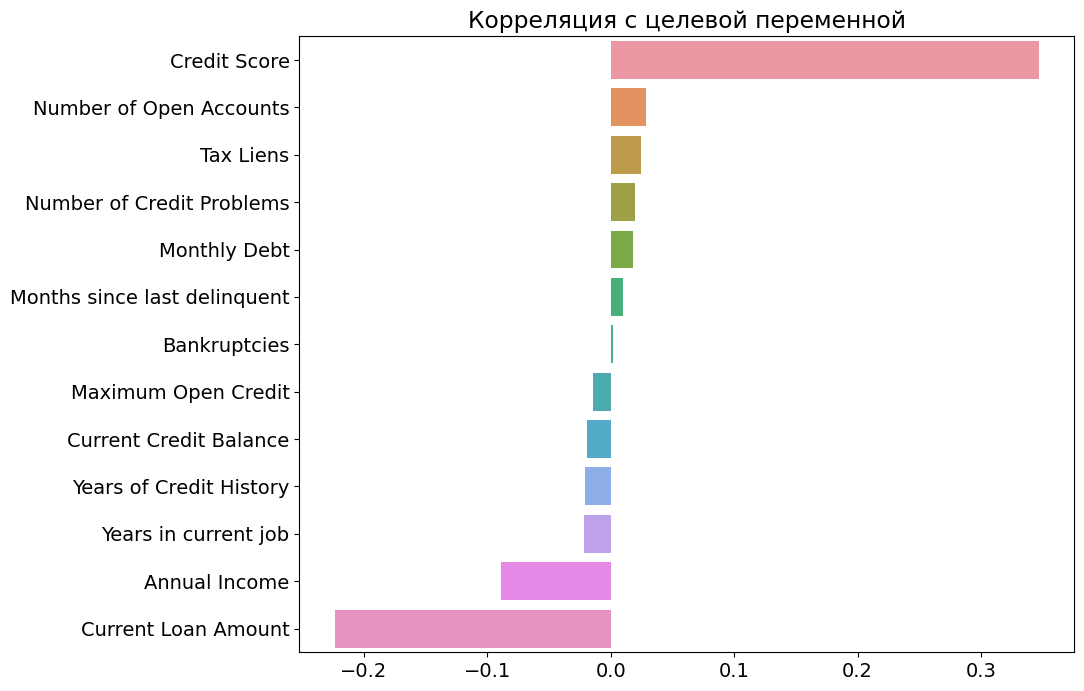

In [33]:
corr_with_target = train_df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Корреляция с целевой переменной')
plt.show()

Как видно, признак Bankruptcies имеет фактически нулевое влияние на целевую переменную. Тем не менее, отсавим его при отборе признаков.

In [34]:
train_df.columns.tolist()

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default']

In [35]:
NUMERIC_FEATURE_NAMES = ['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

**Нормализация данных**


In [36]:
scaler = StandardScaler()

df_norm = train_df.copy()
df_norm[NUMERIC_FEATURE_NAMES] = scaler.fit_transform(train_df[NUMERIC_FEATURE_NAMES])

train_df = df_norm.copy()

# **Oбучение модели**

**Разбиение train в пропорции 75/25**

In [37]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df.drop('Credit Default', axis=1), train_df['Credit Default'], train_size=0.75, random_state=42)

In [38]:
# Функция вывода отчетности по итогам работы модели (код из урока)

def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

Воспользуемся моделью CatBoost, т.к. у нас несколько категориальных признаков. Данная модель преобразует категориальные признаки в числовые, уменьшает возникновение переобучения, тем самым повышая точность.

In [39]:
# Подготовим массив категориальных признаков по их индексам, т.к. их нужно указать в явном виде при передаче в CatBoost

categorical_features_indices = np.where((train_df.dtypes == object))[0]
categorical_features_indices

array([ 0, 10, 11])

In [40]:
# Подготовим дисбаланс классов по целевому значению (также требуется при передаче в CatBoost)

disbalance = y_train.value_counts()[0]/y_train.value_counts()[1]
disbalance

2.6266924564796907

In [41]:
# Применим CatBoost c параметрами по умолчанию

model_catb = catb.CatBoostClassifier(silent=True, 
                                     random_state=42, 
                                     cat_features=categorical_features_indices,
                                     class_weights=[1, disbalance])
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_valid)


In [42]:
# Выведем отчетность применения CatBoost c параметрами по умолчанию

get_classification_report(y_train, y_train_pred, y_valid, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.95      0.87      0.91      4074
           1       0.72      0.88      0.79      1551

    accuracy                           0.87      5625
   macro avg       0.83      0.87      0.85      5625
weighted avg       0.89      0.87      0.88      5625

TEST

              precision    recall  f1-score   support

           0       0.81      0.77      0.79      1313
           1       0.52      0.58      0.55       562

    accuracy                           0.71      1875
   macro avg       0.67      0.68      0.67      1875
weighted avg       0.72      0.71      0.72      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1016  297
1                238  324


**Как видно, отличие f1-score на трейне и тесте составляет более 10% для 0 и 1 классов. Налицо явное переобучение.**

Применим кросс-валидацию на 3 фолда с перемешиванием данных для поиска наилучших параметров CatBoost.

In [43]:
params = {'n_estimators':[50, 100, 200, 500], 
          'max_depth':[3, 5, 7, 10],
          'learning_rate':[0.001, 0.01, 0.05, 0.1]}

In [44]:
cv=KFold(n_splits=3, random_state=42, shuffle=True)

In [45]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X_train, y_train)

CPU times: user 2.84 s, sys: 387 ms, total: 3.23 s
Wall time: 4min 50s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x7fba6a8ca050>,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.05,
                                                          0.1],
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [50, 100, 200, 500]},
                   scoring='f1')

In [46]:
rs.best_params_

{'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1}

In [47]:
rs.best_score_

0.5358596696106716

In [48]:
# Применим найденные параметры в финальной модели

final_model = catb.CatBoostClassifier(n_estimators=500, 
                                      max_depth=5, 
                                      learning_rate=0.01,
                                      silent=True, 
                                      random_state=42, 
                                      cat_features=categorical_features_indices,
                                      class_weights=[1, disbalance])
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.78      0.82      4074
           1       0.53      0.67      0.59      1551

    accuracy                           0.75      5625
   macro avg       0.70      0.72      0.70      5625
weighted avg       0.77      0.75      0.75      5625

TEST

              precision    recall  f1-score   support

           0       0.82      0.75      0.78      1313
           1       0.51      0.61      0.56       562

    accuracy                           0.71      1875
   macro avg       0.66      0.68      0.67      1875
weighted avg       0.73      0.71      0.71      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               984  329
1               219  343


**Теперь расхождение по f1-score на трейне и валидации для обоих классов составляет несколько процентов, что свидетельтсвует о минимуме переобучения.**

**Метрики precicion, recall и f1-score соответствуют заданию проекта.**


# **Вывод результата**

Применим final_model для предсказания на тестовом датасете и выведем результат в csv.

In [49]:
test_df["Credit Default"] = final_model.predict(test_df)

In [50]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 2500 non-null   float64
 2   Years in current job          2500 non-null   int64  
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  2500 non-null   float64
 9   Bankruptcies                  2500 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [55]:
test_df.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Rent,1.366922e+06,5,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,0.0,0
1,Rent,2.318380e+05,2,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0,1
2,Home Mortgage,1.152540e+06,4,0.0,10.0,13.7,204600.0,0.0,0.0,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0,1
3,Home Mortgage,1.220313e+06,11,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0,1
4,Home Mortgage,2.340952e+06,7,0.0,11.0,23.6,1207272.0,0.0,0.0,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0,1
5,Home Mortgage,9.225830e+05,6,0.0,26.0,17.5,713174.0,0.0,41.0,0.0,debt consolidation,Short Term,94028.0,135508.0,11148.0,679.0,1
6,Home Mortgage,1.233309e+06,4,0.0,7.0,22.0,376420.0,0.0,43.0,0.0,home improvements,Short Term,454388.0,292904.0,8181.0,685.0,1
7,Rent,1.215867e+06,4,0.0,13.0,12.2,195888.0,0.0,19.0,0.0,debt consolidation,Short Term,407726.0,120099.0,7599.0,701.0,1
8,Rent,1.366922e+06,6,0.0,8.0,9.1,370524.0,0.0,0.0,0.0,major purchase,Short Term,131956.0,237747.0,10112.0,0.0,0
9,Home Mortgage,2.140445e+06,11,1.0,15.0,16.7,867680.0,1.0,9.0,0.0,debt consolidation,Short Term,391336.0,294500.0,18372.0,745.0,1


In [54]:
test_df.to_csv('/content/sample_data/AIvanov_predictions.csv', sep = ',', index=False)